# Introducción a Redes Neuronales 2024 - Trabajo Práctico 1

---




In [1]:
# Importando líbrerias
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset

# Configuración de Pandas
pd.set_option('display.max_columns', None)

In [2]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Lectura del dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#INTRODUCCIÓN
En este trabajo práctico se nos propuso analizar un conjunto de datos de
indicadores de salud de pacientes con diabetes, prediabetes y sin diabetes. El conjunto de datos utilizado fue obtenido de Kaggle (https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv) y consitió en un split de 50-50 de participantes de una encuesta con diabetes y prediabetes (categoría 1) y no diabetes (0). La variable target fue llamda Diabetes_binary y el conjunto de datos presenta 21 variables independientes (explicatorias). El objetivo del trabajo práctico fué, a través del conocimiento adquirido en clases, ajustar diferentes modelos de  redes neurnales (fully conected) para evaluar el impacto de la variación en diferentes hiperparámetros, evaluandolo uno a uno. Para ello primero se realizó un análisis exploratorio para indagar cuales podían ser las variables con más impacto en la presencia de la diabetes, con esta información se hizo una selección de variables para reducir la dimencionalidad del modelo. Posteriormente se probó el ajuste de los modelos variando 5 hiperparámetros:
- Épocas
- Cantiddad de capas ocultas y número neuronas por capa (estos fueron testeados a la ves) - arquitectura
- Función de activación de las neuronas
- Optimizador

A continuación se desarolla el trabajo práctico.

# Análisis exploratorio de los datos

In [4]:
#zip_path = '/content/drive/My Drive/ap profundo/diabetes_binary_5050split_health_indicators_BRFSS2015.csv.zip'
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/My Drive/ap profundo')  # Extrae el archivo en el directorio de trabajo de Colab

# Leer el CSV descomprimido
csv_path = '/content/drive/My Drive/ap profundo/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data = pd.read_csv(csv_path)

# Mostrar las primeras filas
data.info()
data.head()
data.describe() ## la v target está super balanceada por lo que es razonble pensar que se puede usar accuracy como una buena metrica para la evaluación del modelo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,0.788774,0.042721,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,0.408181,0.202228,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


Inspeccionando el data set vemos que no contiene datos faltantes , un n de 70692. Obteniendo las medidas descriptivas (media, mediana, desvío estándar, cuartiles, mínimo y máximo) para todas las variables, vemos que la variable target "Diabetes binary" es una variable binaria donde el 1 es la presencia de diabetes (o prediabetes) y el 0 son pacientes sanos. A su vez vemos que está balanceada (misma cantidad de 0 que de 1) esto se verá más adelante. El data set presenta 21 variables explicatorias con naturaleza diferente. HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, Anyhelthcare, NoDocbcCost, DiffWalk, Sex son todas variables binarias pero con diferente grado de representatividad cada grupo (en el caso del sexo el 0 representa fem y el 1 masc). Hay otras variables categóricas pero con más grupos (ordinales) como Education con 6 grupos, Income con 8 grupos, GenHelth con 5 grupos. MentHlth es una variable continua discreta con rango de 0 30 (días) al igual que PhysHlth. La edad eata dividida en 13 rangos. Finalmente, BMI es una variable continua discreta también que varía desde 12 a 98.
A continuación heremos un pequeño EDA para ver si existe alguna relación a priori con la variable target. Además analizaremos si hay correlaciones entre las variables explicatorias.

## Histogramas para todas las variables y su distribución según si presenta o no diabetes


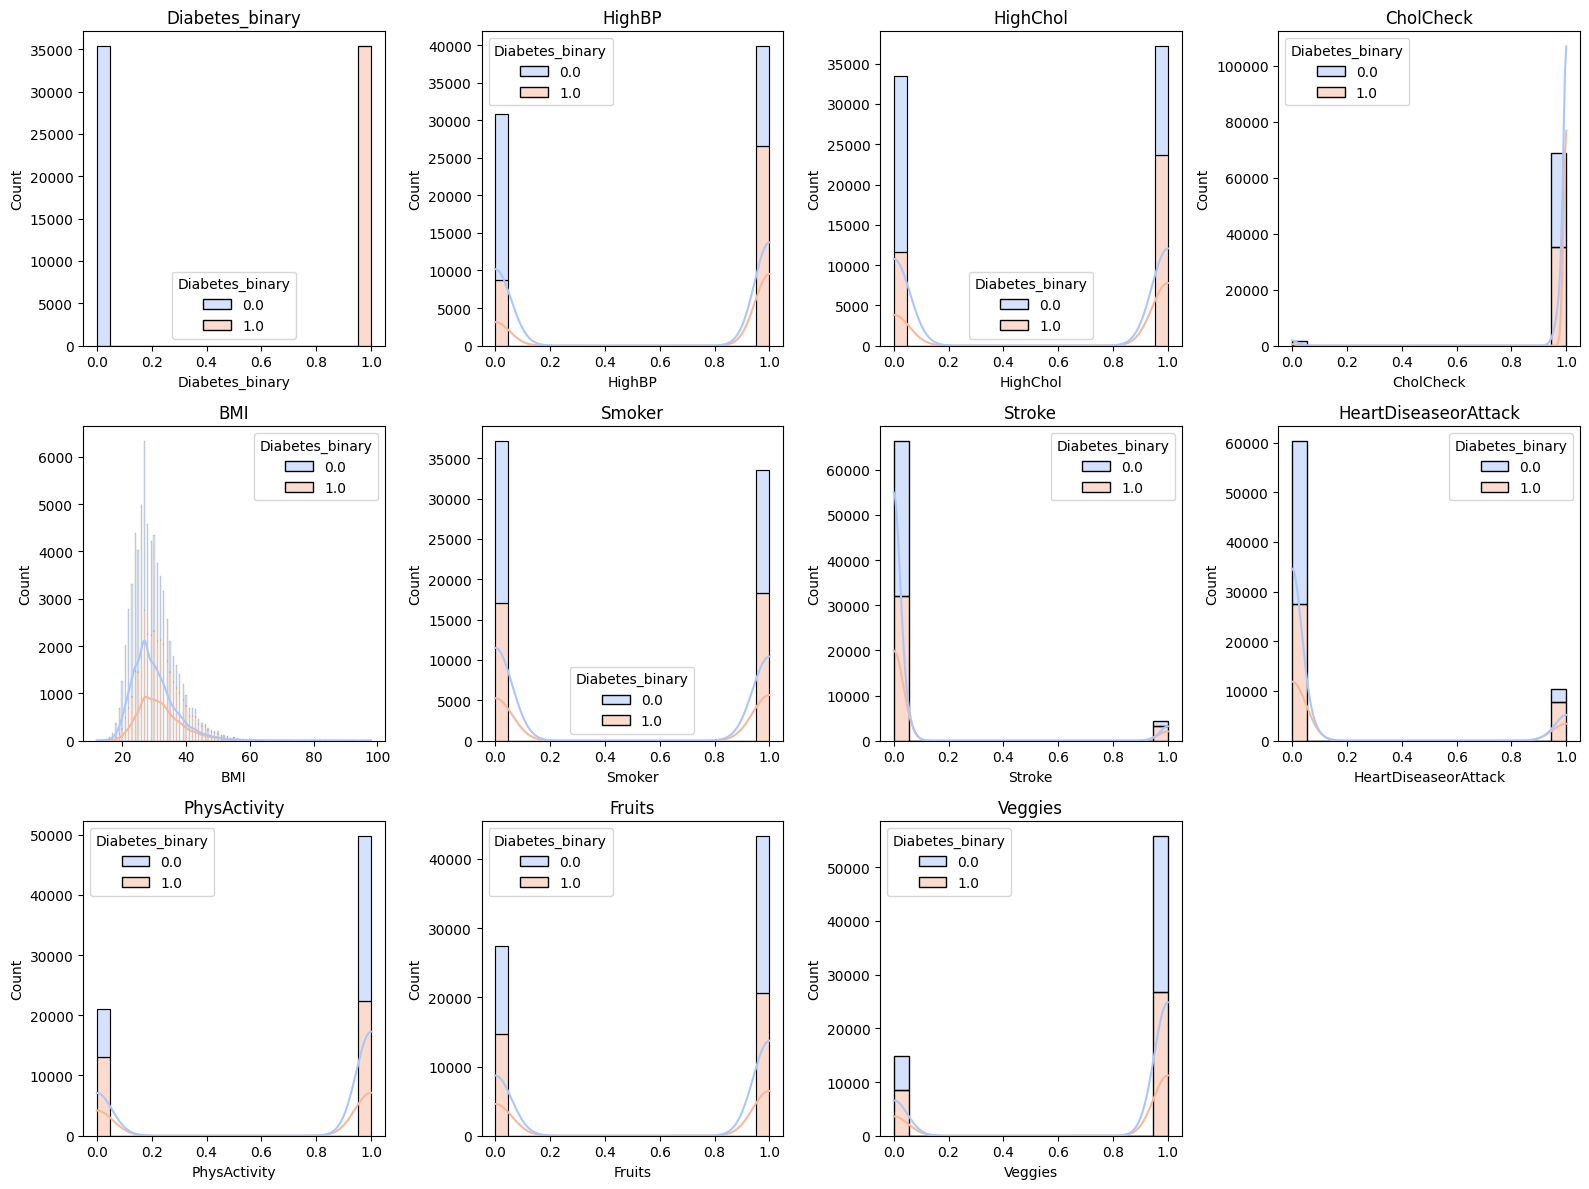

In [5]:
variables1 = ['Diabetes_binary'] + list(data.columns[1:11])  # 'Diabetes_binary' + primeras 10 variables
variables2 = ['Diabetes_binary'] + list(data.columns[11:])   # 'Diabetes_binary' + siguientes 11 variables


plt.figure(figsize=(16, 12))
for i, var in enumerate(variables1, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data, x=var, hue="Diabetes_binary", kde=True, palette="coolwarm", multiple="stack")
    plt.title(var)
plt.tight_layout()
plt.show()



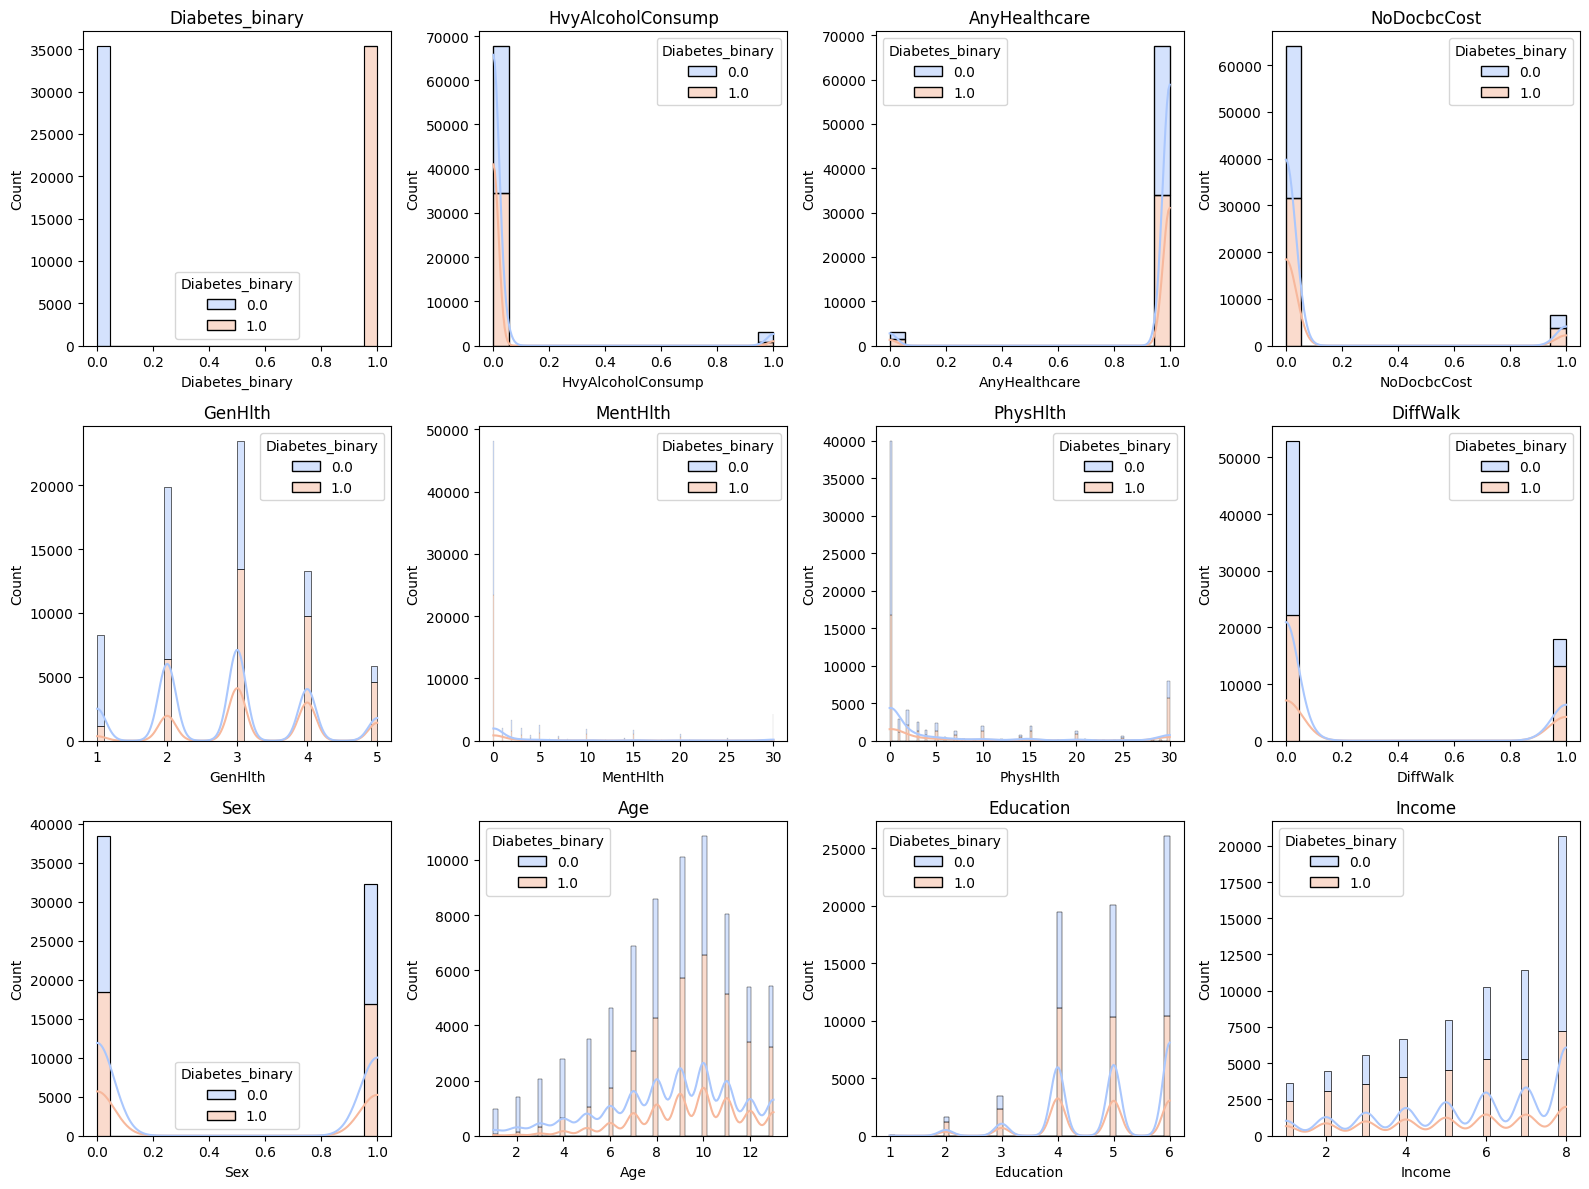

In [ ]:
plt.figure(figsize=(16, 12))
for i, var in enumerate(variables2, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data, x=var, hue="Diabetes_binary", kde=True, palette="coolwarm", multiple="stack")
    plt.title(var)
plt.tight_layout()
plt.show()

Analizando la distribucion de todas las variables según si presenta o no diabetes, aunque no parece haber un efecto muy grande de alguna variable particular, hay algunos patrones que se observan. A continuación se detallan algunas observaciones.
- Diabetes_binary: Es el target y nos muestra que esta balanceado perfectamente. Esto nos permitiría seleccionar la Exactitud (accuracy) como la métrica para evaluar la performance del modelo    
- HighBP: Cuando HighBP es 1 (presente) se observa mayor proporción de enfermos de diabetes.   
- HighCol: Muestra algo muy parecido a lo anterior, pero aparentemente con menor efecto (el cambio de propoción es menor)
- BMI: Sorprendentemente BMI parece no mostrar un efecto muy fuerte sobre la presencia de diabetes, aunque parece estar levemente corrida hacia la derecha para aquellos que tienen diabetes.
- Smoker: Parece mostrar un patrón similar a HighBP y HighCol
- Stroke: La mayoría de los que tuvieron Stroke tienen diabetes (aunque es muy poca la cantidad de pacientes con Stroke)
- HeartDiseaseorAttack: Muy similar a Stroke casi todos los pacientes que tuvieron ataques cardíacos tienen diabetes. La distribución de los enfermos de  diabetes entre los que no tuvieron ataque cardiaco es casi 50/50. Lo que nos indicaría que la diabetes podría provocar ataques cardiacos (probablemente) pero no haber tenido ataques cardíacos no es indicador de que no tengas diabetes.
- Physactivity: La actividad fisica (presencia) parece disminuir la proporción de enfermos de diabetes.
- Fruits y Veggies: El consumo de frutas y la presencia de dietas veggies parece reducir la proporción de enfermos. Es esperable que estas variables esten correlacionadas (veggies tienden a comer frutas) pero eso no se observa en el grafico de correlaciones.
- NoDocbcCost: Esta variable muestra que cuando es 1 (presencia) la proporcion de enfermos aumenta. Es muy baja la cantidad de 1.
- GenHlth: La percepción de la salud personal parece ser importante (y correcta). En los grupos donde se perciben con salud excelente y muy buena la proporción de diabetes es mucho más baja  que en los grupos con percepción de mala salud. Llegando a ser muy alta la proporción de enfermos en los grupos de peor salud.
- PhysHlth: los días con lesiones parece estar vinculado a la diabetes. El grupo que tiene los 30 días con lesiones muestra una proporción muy alta de diabetes respecto a los otros. Hay muchos días con muy pocos pacientes.  y Aquellos que tienen 0 días tienen una distribución muy pareja de 0 y 1 de diabetes. Conclusión similar a HeartDiseasorAtack
- DiffWalk: Cuando existe dificultad para caminar aumenta la prooporción de enfermos de diabetes.
- Sex: No parece haber un efecto del sexo. En el data set hay más fem que masc.
- Age: Parece haber un efecto de la edad en la presencia. A medida que aumenta aumenta la proporción de enfermos, aunque en las grupo 10 11 12 parece estabilizarse (aumenta la edad pero no la proporción de diabetes)
- Education: La educación parece tener un leve efecto. En los grupos más bajos 1, 2 y 3 la proporción de enfermos es alta y en los grupos 4, 5 y 6 disminuye. Aunque la cantidad de pacientes en los grupos 1, 2 y 3 es mucho más baja.
- Income: Parece haber una tendencia a disminuir la proporción de enfermos con el aumento del ingreso.

Debido a esta diferencia en escalas y naturaleza de las variables explicatorias, las mismás serán escaladas.

## GRAFICO DE CALOR PARA EVALUAR CORRELACIONES DE TODAS LAS VARIABLES

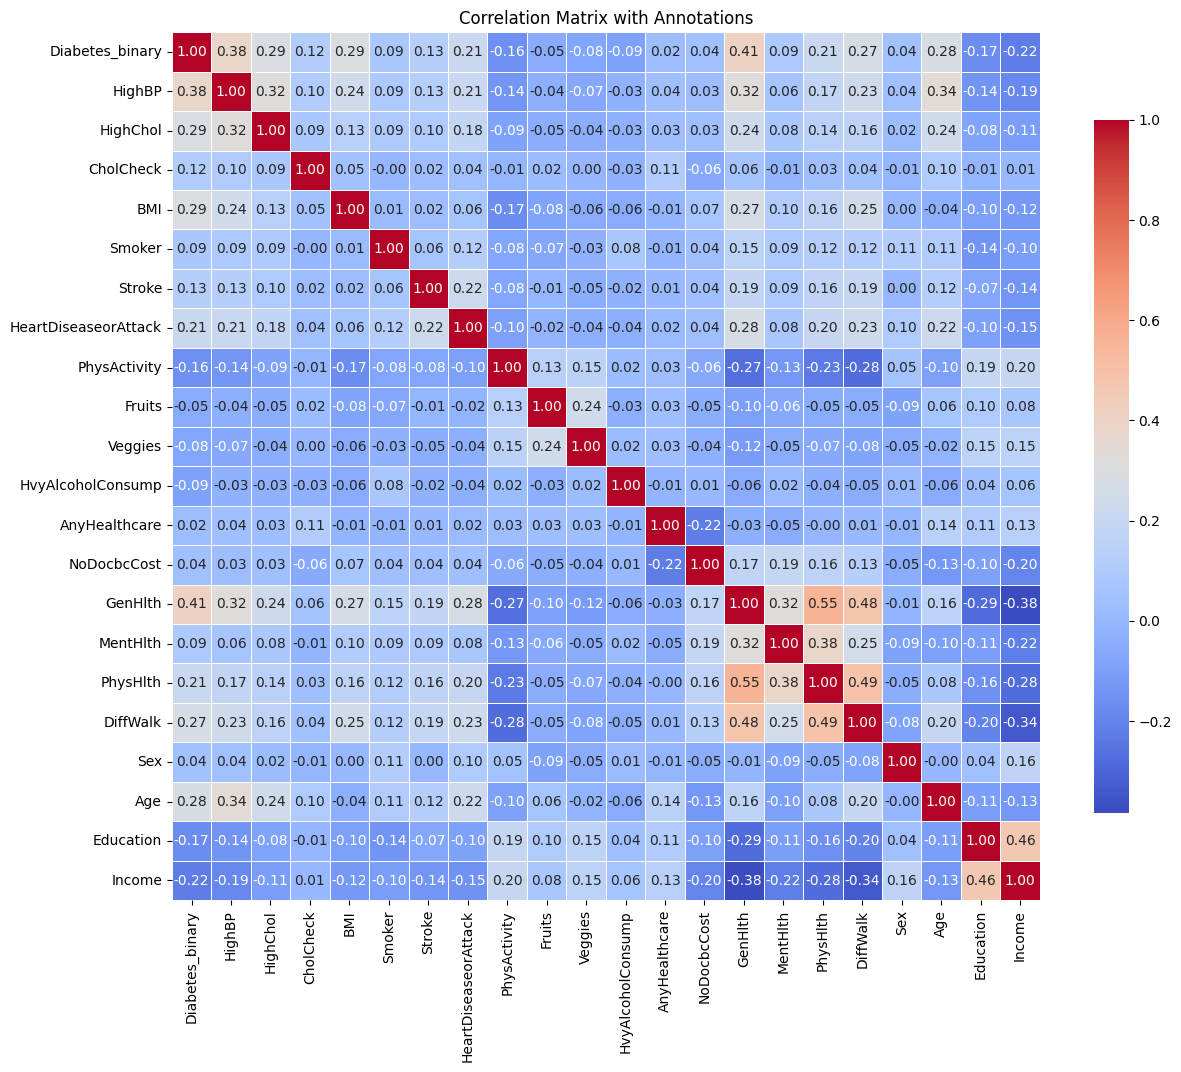

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75}, linewidths=0.5)
plt.title("Correlation Matrix with Annotations")
plt.show()

No parece haber varaibles explicatorias autocorrelacionadas linealmente. La correlacion lineal más alta que se ve es entre GenHlth y PhysHlth de 0.55

Haciendo una lecutra superficial del tema, notamos que puede haber una interacción entre el sexo y la edad donde en edades avanzadas la prevalencia de la diabetes puede ser mayor en varones. A continuación exploramos esta hipótesis.

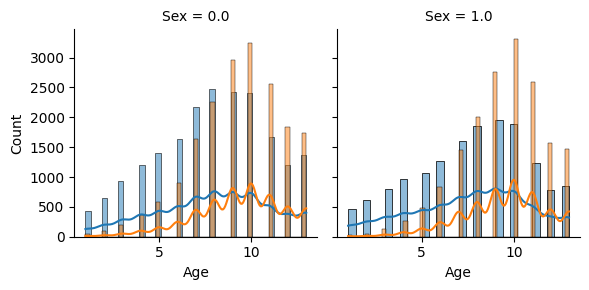

In [ ]:
g = sns.FacetGrid(data, col = 'Sex', hue = 'Diabetes_binary',  sharey=True)
g.map(sns.histplot,'Age', kde = True) ### no parece haber un efecto marcado del sexo
plt.show()

Sin ser muy notorio, en las edades avanzadas parece haber mayor prevalencia de diabetes (mayor proporcion de enfermos vs sanos) en varones (Sex = 1)

## Selección de variables y preparación de los datos

En base a lo que explicamos anteriormente seleccionamos las variables de interés para predecir la presencia de diabetes y pre diabetes. Según nuestro conocimiento la presencia de diabetes puede estar vinculada con un aumento en el Colesterol y la presión sanguínea por lo que estas dos variables serán utilizadas. El BMI aunque en la exploración de datos no parece haber un efecto muy fuerte será incluida por que por bibliografía parece ser un factor de riesgo.
SI fuma o no y la edad son factores de riesgo para la diabetes, al igual que la no actividad física. El sexo es incluido por lo explicado en el punto anterior.
Stroke y HeartDiseaseorAttack son variables muy similares y probablemente vinculadas en terminos médicos por lo que se utilizará una sola de ellas.
La dieta tiene un rol importante en la prevención de la diabetes, en ese sentido comoer frutas y ser vegetarianx puede tener un efecto (Fruits y Veggies) como se mostró en el EDA, estas variables serán incluidas. NoDocbcCost no será incluida debido a que tiene poca presencia (muchos 0s respecto a 1s).
GenHlth serrá incluida ya que parece tener efecto sobre la diabetes. Finalmente se agregó Income al análisis debido a que parece tener un efecto.
Creemos que seleccionamos las variables más importante y a fines prácticos las otras 8 no serán tenidas en cuenta.
Todas las variables explicatorias seleccionadas serán centradas y estandarizadas.


In [6]:
# Crear los tensores de features y target, escalando los datos
scaler = StandardScaler()
# Definir las columnas de features (Modifica según criterio propio)
features_columns = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'Fruits', 'Veggies', 'GenHlth', 'Sex', 'Age', 'PhysActivity', 'DiffWalk','Income']


In [7]:
X = data[features_columns]
y = data['Diabetes_binary']

Estandarizado de las variables

In [8]:
seed = 15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

 ## para la validación

Pasos necesarios de redimensionar los tensores creados para los modelos subsiguientes

In [9]:
X_train_s = torch.Tensor(X_train_s).to(device)  # con Tensor, especificamos que es float
y_train = torch.Tensor(y_train).to(device)  # con LongTensor, especificamos que es int

X_val_s = torch.Tensor(X_val_s).to(device)
y_val = torch.Tensor(y_val).to(device)
X_test_s = torch.Tensor(X_test_s).to(device)
y_test = torch.Tensor(y_test).to(device)

In [10]:
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: torch.Size([49484])
y_val shape: torch.Size([10604])
y_test shape: torch.Size([10604])


In [11]:
## comprobar las formas para que tengan la misma dimension que los predichos del modelo
y_train = torch.Tensor(y_train).squeeze().unsqueeze(1).to(device)
print(f"y_train shape: {y_train.shape}")
y_val = torch.Tensor(y_val).squeeze().unsqueeze(1).to(device)
print(f"y_train shape: {y_val.shape}")
y_test = torch.Tensor(y_test).squeeze().unsqueeze(1).to(device)
print(f"y_train shape: {y_test.shape}")


y_train shape: torch.Size([49484, 1])
y_train shape: torch.Size([10604, 1])
y_train shape: torch.Size([10604, 1])


## Creación de clases y funciones
Creamos clases y funciones que nos ayudarán a llevar a cabo el entrenamiento de los modelos de redes para el análisis de los datos.

creamos clase para eraly stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

Funciones de entrenamiento y validación

In [13]:
## vamos a hacer una funcion para train y una para validation para usar en experimentos
def train_epoch(model, optimizer,  X_train_s, y_train, epoch):

    model.to(device)
    model.train()  # Activate training mode

    optimizer.zero_grad() #setea todos los gradientes en cero
    y_pred = model.forward(X_train_s) # Foward pass y obtener la prediccion
    criterion = nn.BCEWithLogitsLoss(reduction='mean') #combina la función sigmoide con la binary cross-entropy (BCE). Esto te ahorra aplicar una capa sigmoide manualmente antes de la pérdida.
    epoch_training_loss = criterion(y_pred, y_train) ## calcula la loss para clasificacion binaria
    epoch_training_loss.backward() ## calcula los gradientes de las operaciones realizadas

    optimizer.step()  # realiza paso de optimización, actualizando todos los parametros del modelo (pesos y biases)

    y_pred_c = (y_pred > 0).float() ## obtenemos la clase con mayor probabilidad en cada obs () y_pred > 0 devuelve true or false y ahi eso se transforma a 1.0 o 0.0. logits > 0 es prob mayor a 0.5

    epoch_training_accuracy = accuracy_score(y_train.cpu(), y_pred_c.cpu())

    return epoch_training_loss.item(), epoch_training_accuracy


def validation(model, X_val_s, y_val):
    model.eval()  # Activate evaluation mode
    # Don't calculate gradient speed up the forward pass
    epoch_validation_loss = 0.0
    with torch.no_grad():
      y_pred_val = model.forward(X_val_s)
      criterion = nn.BCEWithLogitsLoss(reduction='mean')
      epoch_validation_loss = criterion(y_pred_val, y_val).item()

      y_pred_c_val = (y_pred_val > 0).float()  ### la funcion de perdida BCEWithLogitsLoss ya que esta pérdida combina la sigmoide y la entropía cruzada en un solo paso.

      # Calculate metrics
      accuracy = accuracy_score(y_val.cpu(), y_pred_c_val.cpu())
      f1 = round(f1_score(y_val.cpu(), y_pred_c_val.cpu(), average='macro'), 4)
    return epoch_validation_loss, (accuracy, f1)

Función de experimento

In [14]:
def run_experiment(model, n_epochs, optimizer, X_train_s, y_train, X_val_s, y_val, stop_early=False, patience=5, delta=0.01, use_tqdm = True):

    register_performance = {
        'epoch': [], 'epoch_training_loss': [], 'epoch_validation_loss': [],
        'training_accuracy': [], 'validation_accuracy': [], 'validation_f1': []
    }
    best_accuracy = 0
    if stop_early:
        early_stopping = EarlyStopping(patience=patience, delta=delta)

    print("Begin training...")

    # Inicializa tqdm para mostrar el progreso del total de épocas
    with tqdm(total=n_epochs, desc="Training Progress", unit="epoch") as pbar:
        for epoch in range(1, n_epochs + 1):
            # Entrena una época
            epoch_training_loss, train_accuracy = train_epoch(model, optimizer, X_train_s, y_train, epoch)

            # Validación después de la época
            epoch_validation_loss, metrics = validation(model, X_val_s, y_val)

            # Imprimir resultados cada 10 épocas

            if use_tqdm:
                if epoch % 10 == 0:
                    print(f"\tEpoch {epoch}: Train accuracy={train_accuracy:.3f}, Validation accuracy={metrics[0]:.3f}")
                # Actualiza tqdm con el progreso solo cada 10 épocas
                    pbar.update(10)

            # Registro de desempeño
            register_performance['epoch'].append(epoch)
            register_performance['epoch_training_loss'].append(epoch_training_loss)
            register_performance['epoch_validation_loss'].append(epoch_validation_loss)
            register_performance['training_accuracy'].append(train_accuracy)
            register_performance['validation_accuracy'].append(metrics[0])
            register_performance['validation_f1'].append(metrics[1])

            # Guarda el mejor modelo basado en la validación
            if metrics[0] > best_accuracy:
                best_model = model
                best_accuracy = metrics[0]

            # Early Stopping
            if stop_early:
                early_stopping(epoch_validation_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping!")
                    break

        # Imprime cuando termina el entrenamiento
        print("Training finished!")

    if stop_early:
        early_stopping.load_best_model(model)

    # Guarda los resultados del experimento
    experiment = {
        'best_model': best_model,
        'optimizer': optimizer,
        'loss': 'BCEWithLogitsLoss',
        'epochs': n_epochs,
        'register_performance': register_performance,
    }

    print(f'Completed training in {epoch} epochs',
          f'\n\t- Training Loss: {epoch_training_loss:.4f}',
          f'\n\t- Validation Loss: {epoch_validation_loss:.4f}',
          f'\n\t- Training Accuracy: {train_accuracy:.4f}',
          f'\n\t- Validation Accuracy: {metrics[0]:.4f}',
          f'\n\t- Validation F1: {metrics[1]:.4f}')

    return experiment

Funcion para obtener las métricas

Es importante destacar que la métrica seleccionada para la evaluación del modelo fue la Exactitud (Accuracy) ya que los grupos de la variable respuesta son balanceados (0s y 1s) por lo que sería una métrica adecuada para evaluar la performance del modelo.

In [15]:
def get_loss_and_metrics_data(experiments_set):
    df_base = pd.DataFrame()
    for experiment in experiments_set:
        arquitecture_str = str(experiment['best_model'])
        model_name = arquitecture_str.split('(')[0]
        activation_function_name = arquitecture_str.split('(')[-2].split(': ')[1]
        optimizer = experiment['optimizer']
        optim = type(optimizer).__name__
        lr = optimizer.param_groups[0]['lr']
        weight_decay = optimizer.param_groups[0]['weight_decay']
        df = pd.DataFrame(experiment['register_performance'])
        df['model-activation-optimizer-lr-wd'] = f'{model_name}-{activation_function_name}-{optim}-{lr}-{weight_decay}'
        df_base = pd.concat([df_base, df])

    df_metrics = df_base.drop(columns=['epoch_training_loss', 'epoch_validation_loss'])
    df_loss = df_base.drop(columns=['training_accuracy', 'validation_accuracy', 'validation_f1']) \
                    .melt(id_vars=['epoch', 'model-activation-optimizer-lr-wd'],
                            value_vars=['epoch_training_loss', 'epoch_validation_loss'],
                            var_name='task', value_name='loss')
    return df_loss, df_metrics

Función para plots

In [16]:
def plot_loss(experiment, title=None):
    df_experiment = pd.DataFrame(experiment)

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sns.lineplot(data=df_experiment, x='epoch', y='epoch_training_loss', color='orange',
                    label='Training', markersize=10, lw=1.5, marker='*', ax=axs[0])
    sns.lineplot(data=df_experiment, x='epoch', y='epoch_validation_loss',
                    label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[0])
    plt.grid('--')
    sns.lineplot(data=df_experiment, x='epoch', y='training_accuracy', color='orange',
                    label='Training', markersize=10, lw=1.5, marker='*', ax=axs[1])
    sns.lineplot(data=df_experiment, x='epoch', y='validation_accuracy',
                    label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[1])
    for i, ax in enumerate(axs.ravel()):
        print(i)
        ax.set_xlabel('Epoch')
        if i < 1:
          ax.set_ylabel('Loss')
        else:
          ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid('--')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.suptitle(title)
    plt.xticks(rotation=40, fontsize=8)
    plt.yticks(fontsize=9)
    plt.show()

def metrics_plots(data):
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    sns.pointplot(data=data, x='epoch', y='training_accuracy', hue='model-activation-optimizer-lr-wd', ax=axs[0])
    sns.pointplot(data=data, x='epoch', y='validation_accuracy', hue='model-activation-optimizer-lr-wd', ax=axs[1])
    sns.pointplot(data=data, x='epoch', y='validation_f1', hue='model-activation-optimizer-lr-wd', ax=axs[2])
    for ax in axs.ravel():
        ax.grid('--')
    plt.show()

Ahora elaboramos un experimento

## MODELO BASE
El modelo base consiste en 2 capas ocultas (hidden layers) en lla que la segunda capa tiene n*2 neuronas respecto a la primera. Luego será evaluado tanto la cantidad de nueronas por capa como modelos con otra arquitectura.

In [17]:
## modelo base , una red fully conected chica para probar algunos hiperparametros
class MLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden*2)
        self.hidden_layer2 = nn.Linear(n_hidden*2, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.activation_function(self.hidden_layer2(x))
        x = self.output_layer(x)  # Output Layer
        return x

# Experimento 1 - Épocas

La primera prueba de hiperparámetros que realizamos para el modelo base fue la cantidad de Épocas. Nuestra idea era evaluar la cantidad de épocas mínimas necesarias para lograr que el modelo se estabilice y aprenda lo suficiente para obtener los parámetros que minimicen la función de pérdida ( muchas veces aunque se aumenten las épocas el modelo no aprende, buscamos opitimizar esto).
El modelo probado fue el base MLP definido anteriormente con hidden_layer1 = 32 y hidden_layer2 = 32*2. Este ultimo devuelve 32 activaciones (datos transformados luego de pasar por la función de activación de ambas capas osucras) que serán tomadas por la capa de salida. Cabe destacar que en este modelo la capa de salida es linnear ya que la función de perdida utilizada en todos los casos es nn.BCEWithLogitsLoss(reduction='mean') que implementa itnernamente el logit, lo que permite no incluir el logit para la clasificacion binaria en la capa de salida.
En resumen este apartado se dejaron fijo los siguientes hiperparámetros:
- Loss = BCEWithLogitsLoss
- Opitimizador = torch.optim.Adam(model.parameters(), lr=0.01)
- hidden_layers = 2 donde la primer capa tuvo 32 neuronas y la sgunda 32*2
- Función de activación = ReLU    

Se probó el hiperparámetro número de épocas en 4 exprimentos:
- 1) 25 épocas
- 2) 50 épocas
- 3) 75 épocas
- 4) 75 épocas con early stopping = True


In [ ]:
print(X_train_s.shape)
print(len(features_columns))

torch.Size([49484, 13])
13


In [19]:
torch.manual_seed(seed)
n_inputs = len(features_columns)
n_hidden = 32
activation_function = F.relu
n_outputs = 1
model = MLP(n_inputs, n_outputs, n_hidden, activation_function) ## modelo base para arrancar solo vamos a probar las epocas


optimizer = torch.optim.Adam(model.parameters(), lr=0.01) ## tambien fijamos
## solo para probar que ande





In [22]:
print('experiment 1')
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment1 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 2')
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment2 = run_experiment(model, n_epochs = 50, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 3')
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment3 = run_experiment(model, n_epochs = 75, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 4')
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment4 = run_experiment(model, n_epochs = 75, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=True, patience=10, delta=0.01, use_tqdm = True)

experiment 1
Begin training...


Training Progress:  40%|████      | 10/25 [00:01<00:01,  9.06epoch/s]

	Epoch 10: Train accuracy=0.742, Validation accuracy=0.741


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 10.80epoch/s]

	Epoch 20: Train accuracy=0.748, Validation accuracy=0.746


Training Progress:  80%|████████  | 20/25 [00:02<00:00,  8.73epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5091 
	- Validation Loss: 0.5129 
	- Training Accuracy: 0.7483 
	- Validation Accuracy: 0.7486 
	- Validation F1: 0.7472
experiment 2
Begin training...


Training Progress:  20%|██        | 10/50 [00:00<00:03, 11.56epoch/s]

	Epoch 10: Train accuracy=0.740, Validation accuracy=0.738


Training Progress:  40%|████      | 20/50 [00:01<00:02, 12.22epoch/s]

	Epoch 20: Train accuracy=0.747, Validation accuracy=0.746


Training Progress:  60%|██████    | 30/50 [00:02<00:01, 12.54epoch/s]

	Epoch 30: Train accuracy=0.751, Validation accuracy=0.751


Training Progress:  80%|████████  | 40/50 [00:03<00:00, 13.38epoch/s]

	Epoch 40: Train accuracy=0.751, Validation accuracy=0.754


Training Progress: 100%|██████████| 50/50 [00:03<00:00, 13.38epoch/s]


	Epoch 50: Train accuracy=0.753, Validation accuracy=0.756
Training finished!
Completed training in 50 epochs 
	- Training Loss: 0.5015 
	- Validation Loss: 0.5071 
	- Training Accuracy: 0.7528 
	- Validation Accuracy: 0.7556 
	- Validation F1: 0.7548
experiment 3
Begin training...


Training Progress:  13%|█▎        | 10/75 [00:00<00:04, 14.01epoch/s]

	Epoch 10: Train accuracy=0.743, Validation accuracy=0.739


Training Progress:  27%|██▋       | 20/75 [00:01<00:03, 13.78epoch/s]

	Epoch 20: Train accuracy=0.747, Validation accuracy=0.746


Training Progress:  40%|████      | 30/75 [00:02<00:03, 13.48epoch/s]

	Epoch 30: Train accuracy=0.750, Validation accuracy=0.749


Training Progress:  53%|█████▎    | 40/75 [00:03<00:02, 13.10epoch/s]

	Epoch 40: Train accuracy=0.752, Validation accuracy=0.753


Training Progress:  67%|██████▋   | 50/75 [00:03<00:02, 12.20epoch/s]

	Epoch 50: Train accuracy=0.753, Validation accuracy=0.751


Training Progress:  80%|████████  | 60/75 [00:05<00:01, 10.95epoch/s]

	Epoch 60: Train accuracy=0.754, Validation accuracy=0.754


Training Progress:  93%|█████████▎| 70/75 [00:06<00:00, 10.19epoch/s]

	Epoch 70: Train accuracy=0.754, Validation accuracy=0.753


Training Progress:  93%|█████████▎| 70/75 [00:06<00:00, 10.41epoch/s]


Training finished!
Completed training in 75 epochs 
	- Training Loss: 0.4996 
	- Validation Loss: 0.5067 
	- Training Accuracy: 0.7541 
	- Validation Accuracy: 0.7532 
	- Validation F1: 0.7524
experiment 4
Begin training...


Training Progress:  13%|█▎        | 10/75 [00:01<00:07,  8.93epoch/s]

	Epoch 10: Train accuracy=0.746, Validation accuracy=0.745


Training Progress:  27%|██▋       | 20/75 [00:02<00:05, 10.06epoch/s]

	Epoch 20: Train accuracy=0.746, Validation accuracy=0.746


Training Progress:  27%|██▋       | 20/75 [00:02<00:06,  8.89epoch/s]

Early stopping!
Training finished!
Completed training in 23 epochs 
	- Training Loss: 0.5103 
	- Validation Loss: 0.5155 
	- Training Accuracy: 0.7472 
	- Validation Accuracy: 0.7460 
	- Validation F1: 0.7445


0
1


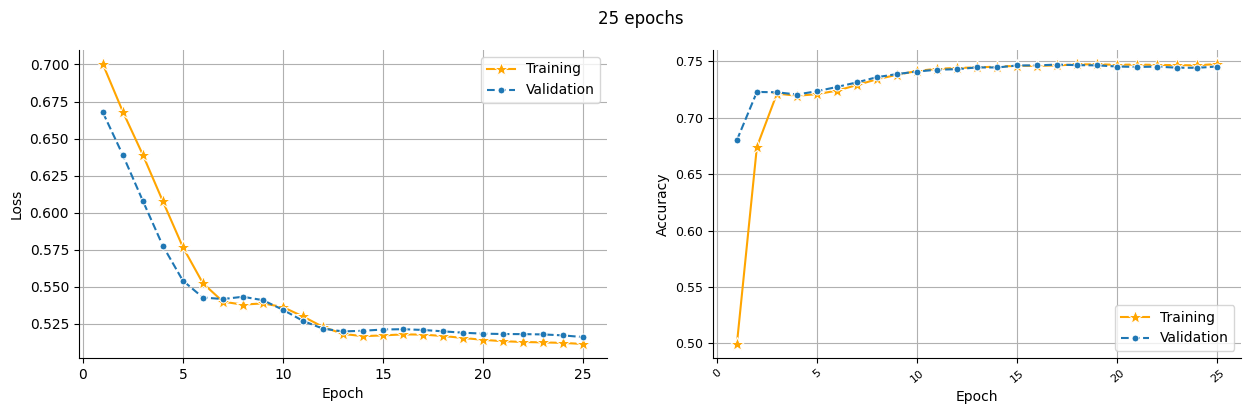

0
1


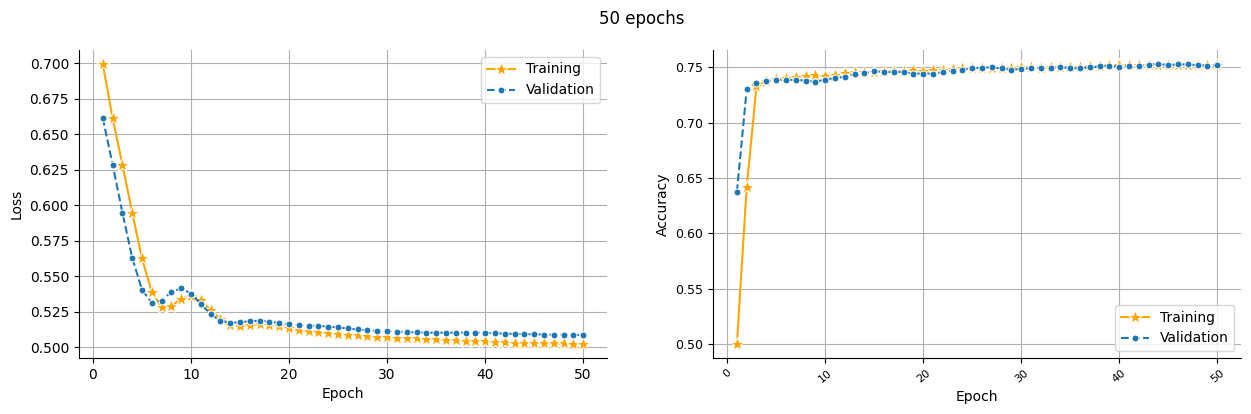

0
1


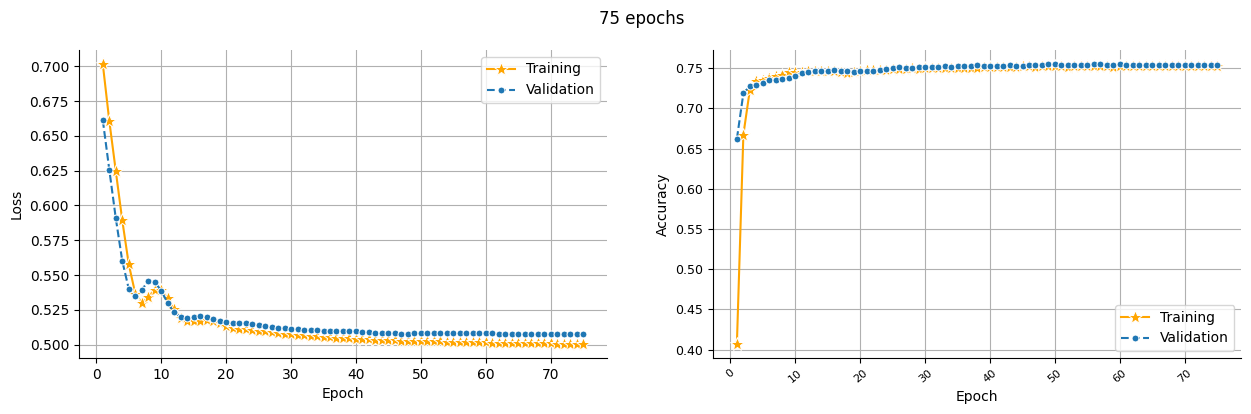

0
1


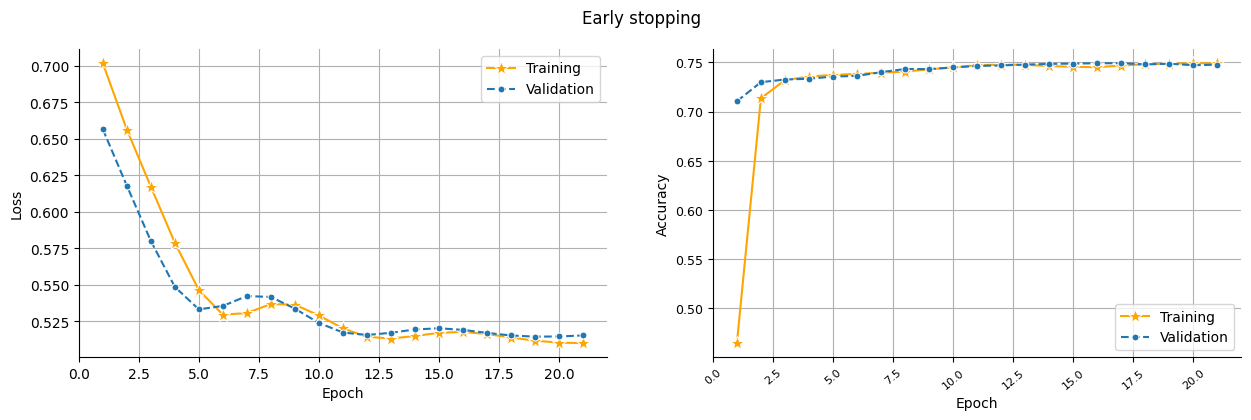

In [ ]:
plot_loss(experiment1['register_performance'], '25 epochs')
plot_loss(experiment2['register_performance'], '50 epochs')
plot_loss(experiment3['register_performance'], '75 epochs')
plot_loss(experiment4['register_performance'], 'Early stopping')

Analizando las curvas obtenidas del entrenamiento, vemos que en ninguno de los casos parece  haber sobre ajuste, es decir el accuracy de el train y la validación al final del entrenamiento y no hay un punto en el que el entrenamiento siga mejorando y la validación no (lo mismo aplica para la función deperdida con su disminución). Cómo conclusión de estos experimentos, podemos ver que en todos los casos el modelo se estabiliza y no aprende más luego de la época 20, incluso usando el early stopping el modelo corta el entrenamiento en la época 21. Es por esto que utilizaremos 25 épocas para el resto de los experimentos (sumamos 4 por una posible variación que pueda existir).
Entendemos que todos los conjuntos de hiperparámetros porbados deberían probarse a la vez (grid search) ya que otros modelos con diferente arquitectura en este caso podrían necesitar más épocas. A fines del práctico hemos probado de a un hiperparámetro (esta aclración es aplicable al resto de los exprimentos) por eso hemso decidido elegir 25 épocas como n.

# Experimento 2 - diferentes arquitecturas: Tamaño y número de capas ocultas
A continuación realizamos diferentes experimentos para probar modelos con diferentes arquitecturas, particularmente difiriendo en número de capas ocultas y cantidad de neuronas de esas capas respecto al modelo base.
Dejando fijo los hiperparámmetros siguientes:   
- Loss = BCEWithLogitsLoss
- Opitimizador = torch.optim.Adam(model.parameters(), lr=0.01)
- Función de activación = ReLU
- Número de épocas = 25

Se realizaron los siguientes 5 experimentos:
- 1) Modelo base = 2 capas ocultas de 32 y 32*2 neuronas respectivamente
- 2) Modelo simple = 1 capa oculta unicamente de 32 neuronas
- 3) Modelo grande = 4 capas ocultas donde cada capa oculta subsiguiente tiene n*2 más neuronas que la capa anterior, arrancando la primera capa oculta con 32.
- 4) Modelo grande con menos neuronas = 4 capas ocultas con la primer capa con 32 neuronas , y el resto de 32*2 neuronas.
- 5) Modelo con más capas = 7 capas ocultas con 32 neuronas la primer capa oculta y 32*2 el resto de las capas (no van en aumento)

Cabe destacar que en todos los casos el n de activadores de la capa de salida fue de 32.

In [ ]:
## mas simpple quel base menos capas igual neuronas en la capa 1
class simpleMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.output_layer(x)  # Output Layer
        return x

## mas cantidad de capas mas neuronas
class bigMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden*2)
        self.hidden_layer2 = nn.Linear(n_hidden*2, n_hidden*4)
        self.hidden_layer3 = nn.Linear(n_hidden*4, n_hidden*8)
        self.hidden_layer4 = nn.Linear(n_hidden*8, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.activation_function(self.hidden_layer2(x))
        x = self.activation_function(self.hidden_layer3(x))
        x = self.activation_function(self.hidden_layer4(x))
        x = self.output_layer(x)  # Output Layer
        return x

## misma cantidad de layers menos neuronas que el big
class lessbigMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden*2)
        self.hidden_layer2 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer3 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer4 = nn.Linear(n_hidden*2, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.activation_function(self.hidden_layer2(x))
        x = self.activation_function(self.hidden_layer3(x))
        x = self.activation_function(self.hidden_layer4(x))
        x = self.output_layer(x)  # Output Layer
        return x

class mlayers_bigMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden*2)
        self.hidden_layer2 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer3 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer4 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer5 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer6 = nn.Linear(n_hidden*2, n_hidden*2)
        self.hidden_layer7 = nn.Linear(n_hidden*2, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.activation_function(self.hidden_layer2(x))
        x = self.activation_function(self.hidden_layer3(x))
        x = self.activation_function(self.hidden_layer4(x))
        x = self.activation_function(self.hidden_layer5(x))
        x = self.activation_function(self.hidden_layer6(x))
        x = self.activation_function(self.hidden_layer7(x))
        x = self.output_layer(x)  # Output Layer
        return x

In [ ]:
n_inputs = len(features_columns)
n_hidden = 32 ## poquito para arrancar
activation_function = F.relu
n_outputs = 1

In [ ]:
print('Experiment 1 = base model')
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment1 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('Experiment  = simple model')
model = simpleMLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment2 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('Experiment  = big model')
model = bigMLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment3 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('Experiment  = big model smaller hidden layers')
model = lessbigMLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment4 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('Experiment  = more layers')
model = mlayers_bigMLP(n_inputs, n_outputs, n_hidden, activation_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment5 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

Experiment 1 = base model
Begin training...


Training Progress:  40%|████      | 10/25 [00:01<00:01,  9.14epoch/s]

	Epoch 10: Train accuracy=0.742, Validation accuracy=0.741


Training Progress:  80%|████████  | 20/25 [00:02<00:00,  8.40epoch/s]

	Epoch 20: Train accuracy=0.748, Validation accuracy=0.751


Training Progress:  80%|████████  | 20/25 [00:02<00:00,  6.75epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5092 
	- Validation Loss: 0.5147 
	- Training Accuracy: 0.7472 
	- Validation Accuracy: 0.7492 
	- Validation F1: 0.7477
Experiment  = simple model
Begin training...


Training Progress:  40%|████      | 10/25 [00:00<00:00, 18.26epoch/s]

	Epoch 10: Train accuracy=0.729, Validation accuracy=0.729


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 17.48epoch/s]

	Epoch 20: Train accuracy=0.744, Validation accuracy=0.744


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 14.16epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5156 
	- Validation Loss: 0.5176 
	- Training Accuracy: 0.7458 
	- Validation Accuracy: 0.7459 
	- Validation F1: 0.7453
Experiment  = big model
Begin training...


Training Progress:  40%|████      | 10/25 [00:06<00:09,  1.63epoch/s]

	Epoch 10: Train accuracy=0.745, Validation accuracy=0.748


Training Progress:  80%|████████  | 20/25 [00:12<00:03,  1.58epoch/s]

	Epoch 20: Train accuracy=0.751, Validation accuracy=0.751


Training Progress:  80%|████████  | 20/25 [00:16<00:04,  1.22epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5039 
	- Validation Loss: 0.5083 
	- Training Accuracy: 0.7515 
	- Validation Accuracy: 0.7534 
	- Validation F1: 0.7527
Experiment  = big model smaller hidden layers
Begin training...


Training Progress:  40%|████      | 10/25 [00:01<00:02,  5.91epoch/s]

	Epoch 10: Train accuracy=0.744, Validation accuracy=0.741


Training Progress:  80%|████████  | 20/25 [00:03<00:00,  5.59epoch/s]

	Epoch 20: Train accuracy=0.747, Validation accuracy=0.745


Training Progress:  80%|████████  | 20/25 [00:04<00:01,  4.61epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5073 
	- Validation Loss: 0.5126 
	- Training Accuracy: 0.7494 
	- Validation Accuracy: 0.7492 
	- Validation F1: 0.7490
Experiment  = more layers
Begin training...


Training Progress:  40%|████      | 10/25 [00:02<00:04,  3.38epoch/s]

	Epoch 10: Train accuracy=0.705, Validation accuracy=0.715


Training Progress:  80%|████████  | 20/25 [00:06<00:01,  3.10epoch/s]

	Epoch 20: Train accuracy=0.748, Validation accuracy=0.747


Training Progress:  80%|████████  | 20/25 [00:08<00:02,  2.41epoch/s]

Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5134 
	- Validation Loss: 0.5206 
	- Training Accuracy: 0.7494 
	- Validation Accuracy: 0.7475 
	- Validation F1: 0.7464


0
1


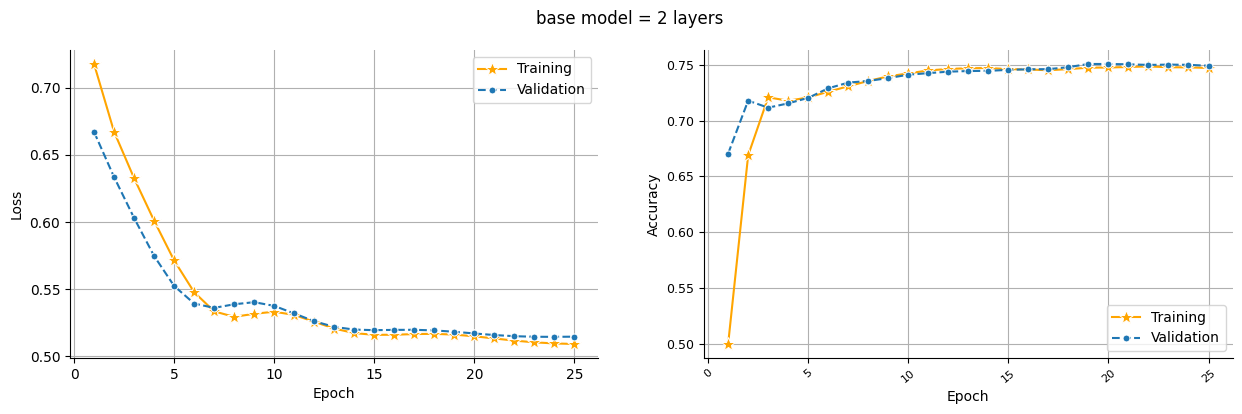

0
1


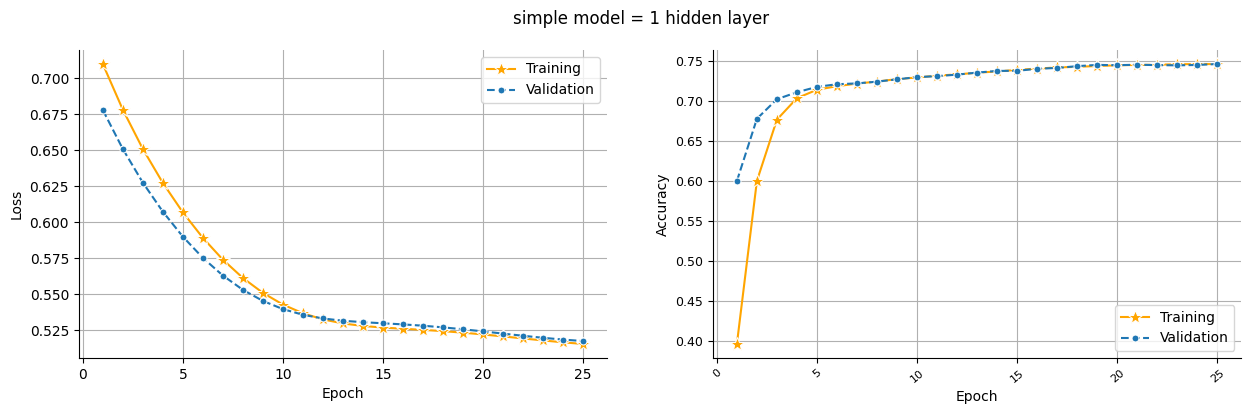

0
1


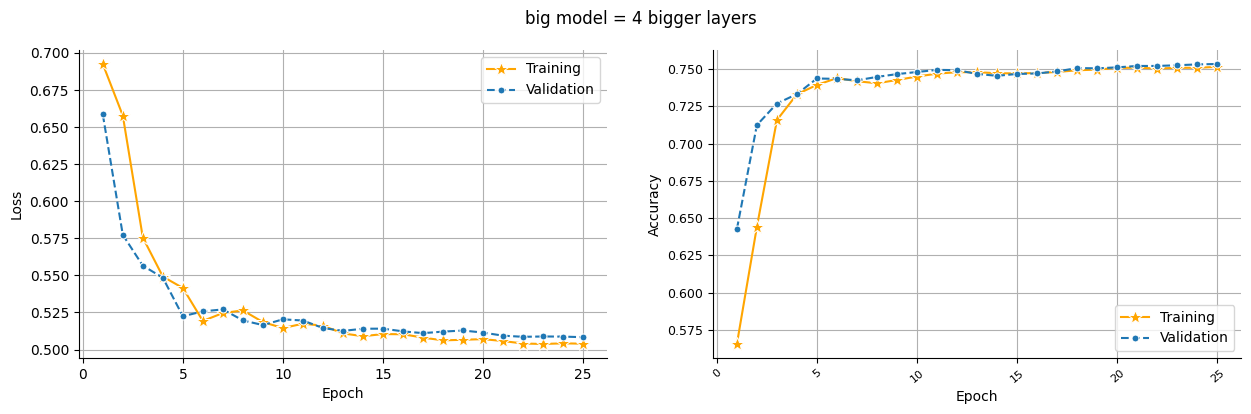

0
1


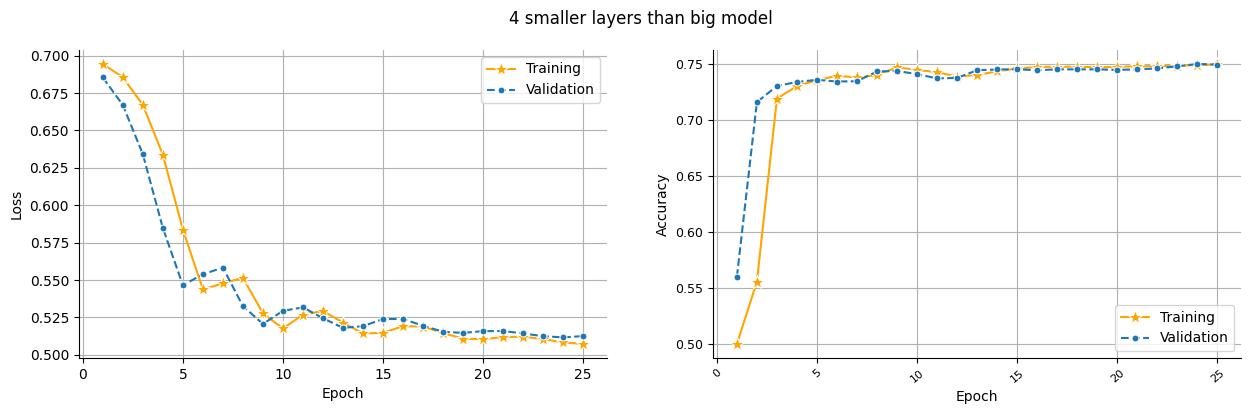

0
1


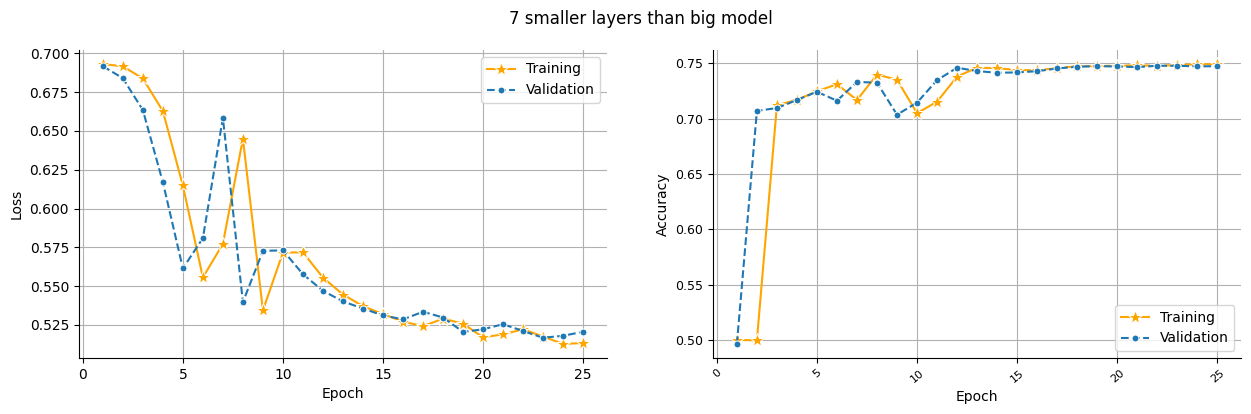

In [ ]:
plot_loss(experiment1['register_performance'], 'base model = 2 layers ')
plot_loss(experiment2['register_performance'], 'simple model = 1 hidden layer')
plot_loss(experiment3['register_performance'], 'big model = 4 bigger layers')
plot_loss(experiment4['register_performance'], '4 smaller layers than big model')
plot_loss(experiment5['register_performance'], '7 smaller layers than big model')

Analizando las curvas podemos ver que todos los modelo parecen tener resultados muy similares, en ningun caso se observa sobreajuste (lo mismo que lo explicado en el punto anterior). El número de épocas = 25 parece ser el adecuado ya que las curvas no muestran una tendencia de que el modelo pueda seguir aprendiendo. Cabe destacar que el modelo 5 (7 hidden layers) tiene un comportamiento extraño en la función de pérdida en las epocas entre 5 y 10 probalbemente por que tenga muchos parametros aunque luego se estabiliza.    
La accuracy final en train y en la validación está cerca de 0.75 siendo el de mejores resultados considerando esta métrica el big model (experimento 3) con Accuracy de entrenamiento = 0.7515 y validación = 0.7534 (llama la atención que la accuracy es más alta en la validación aunque por muy pocos decimales) pero no creemos que haya diferencias muy grandes con el resto como para seleccionar el modelo con más complejo en cantidad de parámetros a estimar. En ese sentido creemos que el modelo base es un buen balance de complejidad y accuracy obtenida (solo difiere en decimales). **Modelo elegido = MODELO 1 BASE.**


# Experimento 3 - Función de activación
A continuación realizamos diferentes experimentos para probar modelos con diferentes funciones de activación utilizando el modelo base MLP porbado en el punto anterior pero variando este hiperparametro.
- Hiperparámetros fijos:
- Loss = BCEWithLogitsLoss
- Opitimizador = torch.optim.Adam(model.parameters(), lr=0.01)
- Número de capas ocultas y cantidad de neuronas por capa:  2 capas ocultas de 32 y 32*2 neuronas respectivamente
- Número de épocas = 40. Se aumentó el número de épocas a 40 ya que usando la función de activación sigmoide, la gráfica mostraba que aún el apredizaje podía continuar por lo que se uso 40 épocas para el resto de los experimentos también para poder dejar fijo este hiperparametro y no introducir variación que no sea por la función de activación.  

Se probó el hiperparámetro función de activación con 4 posibles funciones probadas:
- ReLU
- Sigmoide
- Tanh
- Leaky Relu

In [ ]:
n_hidden = 32
activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': F.relu,
    'LeakyReLU': nn.LeakyReLU()
}


In [ ]:
## mismo modelo que antes
print('experiment 1 = Funcion de activacion ReLU')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['ReLU'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment1 = run_experiment(model, n_epochs = 40, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 2 = Funcion de activacion Sigmoide')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['Sigmoid'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment2 = run_experiment(model, n_epochs = 40, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 3 = Funcion de activacion Tanh')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['Tanh'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment3 = run_experiment(model, n_epochs = 40, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 4 = Funcion de activacion Leaky ReLU')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['LeakyReLU'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment4 = run_experiment(model, n_epochs = 40, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

experiment 1 = Funcion de activacion ReLU
Begin training...


Training Progress:  25%|██▌       | 10/40 [00:01<00:03,  9.44epoch/s]

	Epoch 10: Train accuracy=0.745, Validation accuracy=0.741


Training Progress:  50%|█████     | 20/40 [00:02<00:02,  9.23epoch/s]

	Epoch 20: Train accuracy=0.747, Validation accuracy=0.745


Training Progress:  75%|███████▌  | 30/40 [00:03<00:01,  7.21epoch/s]

	Epoch 30: Train accuracy=0.750, Validation accuracy=0.749


Training Progress: 100%|██████████| 40/40 [00:05<00:00,  7.17epoch/s]


	Epoch 40: Train accuracy=0.751, Validation accuracy=0.752
Training finished!
Completed training in 40 epochs 
	- Training Loss: 0.5041 
	- Validation Loss: 0.5091 
	- Training Accuracy: 0.7510 
	- Validation Accuracy: 0.7517 
	- Validation F1: 0.7507
experiment 2 = Funcion de activacion Sigmoide
Begin training...


Training Progress:  25%|██▌       | 10/40 [00:01<00:03,  9.29epoch/s]

	Epoch 10: Train accuracy=0.529, Validation accuracy=0.642


Training Progress:  50%|█████     | 20/40 [00:02<00:02,  9.52epoch/s]

	Epoch 20: Train accuracy=0.729, Validation accuracy=0.726


Training Progress:  75%|███████▌  | 30/40 [00:02<00:00, 10.89epoch/s]

	Epoch 30: Train accuracy=0.735, Validation accuracy=0.730


Training Progress: 100%|██████████| 40/40 [00:03<00:00, 11.02epoch/s]


	Epoch 40: Train accuracy=0.742, Validation accuracy=0.738
Training finished!
Completed training in 40 epochs 
	- Training Loss: 0.5343 
	- Validation Loss: 0.5378 
	- Training Accuracy: 0.7423 
	- Validation Accuracy: 0.7377 
	- Validation F1: 0.7377
experiment 3 = Funcion de activacion Tanh
Begin training...


Training Progress:  25%|██▌       | 10/40 [00:00<00:02, 12.13epoch/s]

	Epoch 10: Train accuracy=0.746, Validation accuracy=0.743


Training Progress:  50%|█████     | 20/40 [00:01<00:01, 11.95epoch/s]

	Epoch 20: Train accuracy=0.745, Validation accuracy=0.744


Training Progress:  75%|███████▌  | 30/40 [00:02<00:00, 11.98epoch/s]

	Epoch 30: Train accuracy=0.748, Validation accuracy=0.747


Training Progress: 100%|██████████| 40/40 [00:03<00:00, 11.98epoch/s]


	Epoch 40: Train accuracy=0.749, Validation accuracy=0.747
Training finished!
Completed training in 40 epochs 
	- Training Loss: 0.5109 
	- Validation Loss: 0.5133 
	- Training Accuracy: 0.7488 
	- Validation Accuracy: 0.7470 
	- Validation F1: 0.7465
experiment 4 = Funcion de activacion Leaky ReLU
Begin training...


Training Progress:  25%|██▌       | 10/40 [00:00<00:02, 13.60epoch/s]

	Epoch 10: Train accuracy=0.746, Validation accuracy=0.741


Training Progress:  50%|█████     | 20/40 [00:01<00:01, 13.45epoch/s]

	Epoch 20: Train accuracy=0.748, Validation accuracy=0.749


Training Progress:  75%|███████▌  | 30/40 [00:02<00:00, 13.61epoch/s]

	Epoch 30: Train accuracy=0.749, Validation accuracy=0.748


Training Progress: 100%|██████████| 40/40 [00:02<00:00, 13.58epoch/s]

	Epoch 40: Train accuracy=0.751, Validation accuracy=0.752
Training finished!
Completed training in 40 epochs 
	- Training Loss: 0.5045 
	- Validation Loss: 0.5097 
	- Training Accuracy: 0.7509 
	- Validation Accuracy: 0.7520 
	- Validation F1: 0.7512


0
1


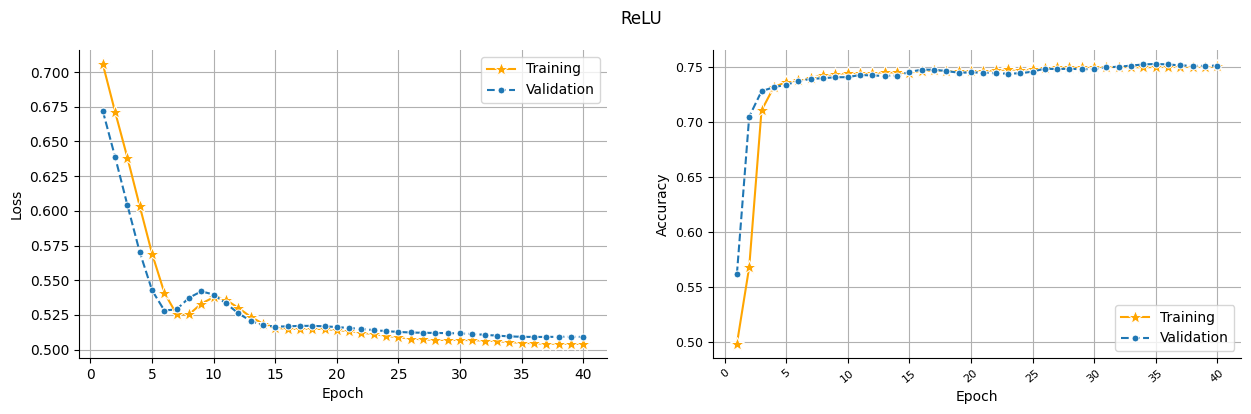

0
1


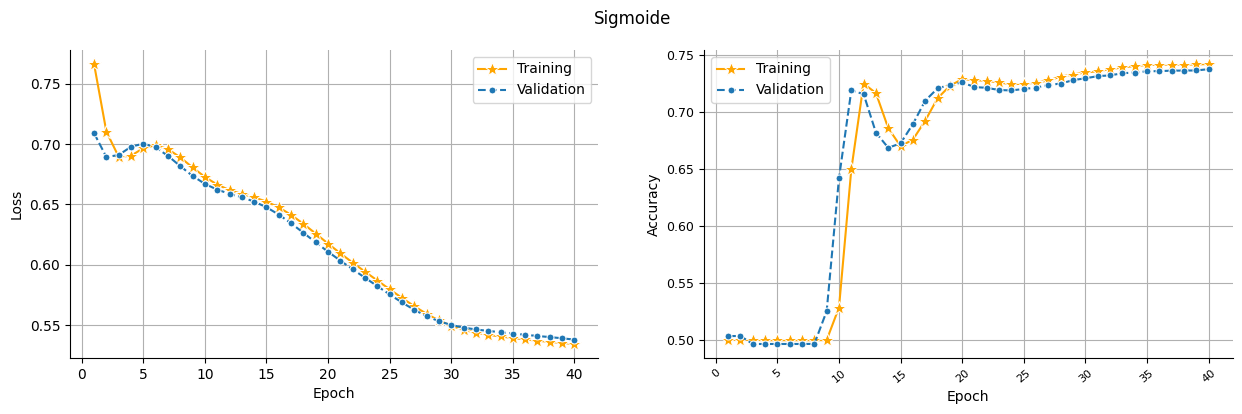

0
1


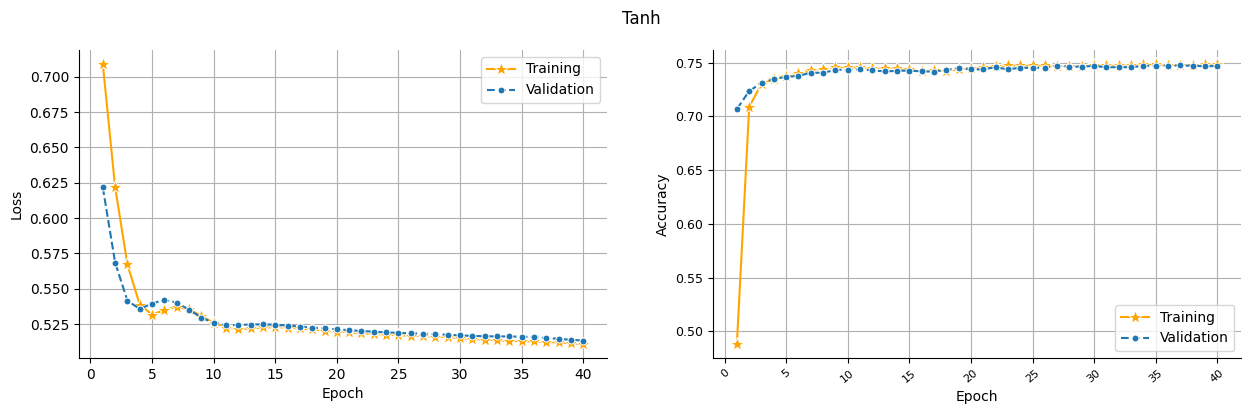

0
1


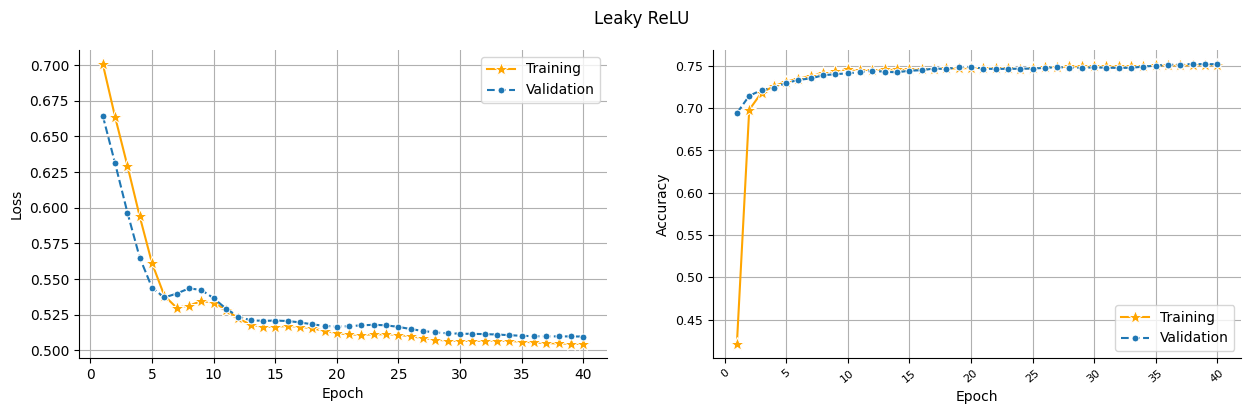

In [ ]:
plot_loss(experiment1['register_performance'], 'ReLU')
plot_loss(experiment2['register_performance'], 'Sigmoide')
plot_loss(experiment3['register_performance'], 'Tanh')
plot_loss(experiment4['register_performance'], 'Leaky ReLU')

Al igual que en resultados anteriores ninguna gráfica muestra sobreajuste, tanto en el entrenamiento como en la validación (tanto para la accuracy como para la función de pérdida) se obtienen resultados similares y sin una brecha importante entre ellas. Todas las funciones de activación obtienen Accutacy y valores de f. de pérdida similares al final del entrenamiento siendo la ReLU y la Leaky ReLU las de mejor ajuste: ReLU(Validation Loss: 0.5091, Validation Accuracy: 0.7517) leaky ReLU( Validation Loss: 0.5097, Validation Accuracy: 0.7520 ). Continuaremos utilizando ReLU.


# Experimento 4 - Opitimizador
A continuación realizamos diferentes experimentos para probar modelos con diferentes optimizadores, dejando fijo los hiperparámmetros siguientes:
- Loss = BCEWithLogitsLoss
- Opitimizador = torch.optim.Adam(model.parameters(), lr=0.01)
- Función de activación = ReLU
- Número de épocas = 25
- Modelo base (MLP) = 2 capas ocultas de 32 y 32*2 neuronas respectivamente

Se probaron 4 optimizadores diferentes:
- Adam (El utilizado anteriormente)
- SGD
- Momentum
- Adagrad

Cabe destacar que a su vez en cada uno se podrían probar diferentes learnings rate y otros hiperparámetros que no fueron testeados en este práctico.

In [ ]:
n_hidden = 32

In [ ]:
print('experiment 1 = optimizador Adam')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['ReLU'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
experiment1 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 2 = SGD')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['ReLU'])
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)
experiment2 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 3 = Momentum')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['ReLU'])
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
experiment3 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

print('experiment 4 = Adagrad')
model = MLP(n_inputs, n_outputs, n_hidden, activation_functions['ReLU'])
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
experiment3 = run_experiment(model, n_epochs = 25, optimizer = optimizer,  X_train_s = X_train_s, y_train = y_train, X_val_s = X_val_s, y_val = y_val, stop_early=False, patience=10, delta=0.01, use_tqdm = True)

experiment 1 = optimizador Adam
Begin training...


Training Progress:  40%|████      | 10/25 [00:00<00:01, 14.00epoch/s]

	Epoch 10: Train accuracy=0.747, Validation accuracy=0.746


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 13.96epoch/s]

	Epoch 20: Train accuracy=0.749, Validation accuracy=0.749


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 11.06epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5073 
	- Validation Loss: 0.5125 
	- Training Accuracy: 0.7501 
	- Validation Accuracy: 0.7504 
	- Validation F1: 0.7489
experiment 2 = SGD
Begin training...


Training Progress:  40%|████      | 10/25 [00:00<00:01, 13.88epoch/s]

	Epoch 10: Train accuracy=0.729, Validation accuracy=0.726


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 11.48epoch/s]

	Epoch 20: Train accuracy=0.737, Validation accuracy=0.735


Training Progress:  80%|████████  | 20/25 [00:02<00:00,  9.13epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5307 
	- Validation Loss: 0.5312 
	- Training Accuracy: 0.7402 
	- Validation Accuracy: 0.7389 
	- Validation F1: 0.7382
experiment 3 = Momentum
Begin training...


Training Progress:  40%|████      | 10/25 [00:00<00:01, 10.46epoch/s]

	Epoch 10: Train accuracy=0.716, Validation accuracy=0.720


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 10.34epoch/s]

	Epoch 20: Train accuracy=0.746, Validation accuracy=0.743


Training Progress:  80%|████████  | 20/25 [00:02<00:00,  8.26epoch/s]


Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5205 
	- Validation Loss: 0.5246 
	- Training Accuracy: 0.7449 
	- Validation Accuracy: 0.7477 
	- Validation F1: 0.7468
experiment 4 = Adagrad
Begin training...


Training Progress:  40%|████      | 10/25 [00:00<00:01, 11.27epoch/s]

	Epoch 10: Train accuracy=0.747, Validation accuracy=0.745


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 12.83epoch/s]

	Epoch 20: Train accuracy=0.748, Validation accuracy=0.747


Training Progress:  80%|████████  | 20/25 [00:01<00:00, 10.31epoch/s]

Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5077 
	- Validation Loss: 0.5118 
	- Training Accuracy: 0.7487 
	- Validation Accuracy: 0.7491 
	- Validation F1: 0.7480


0
1


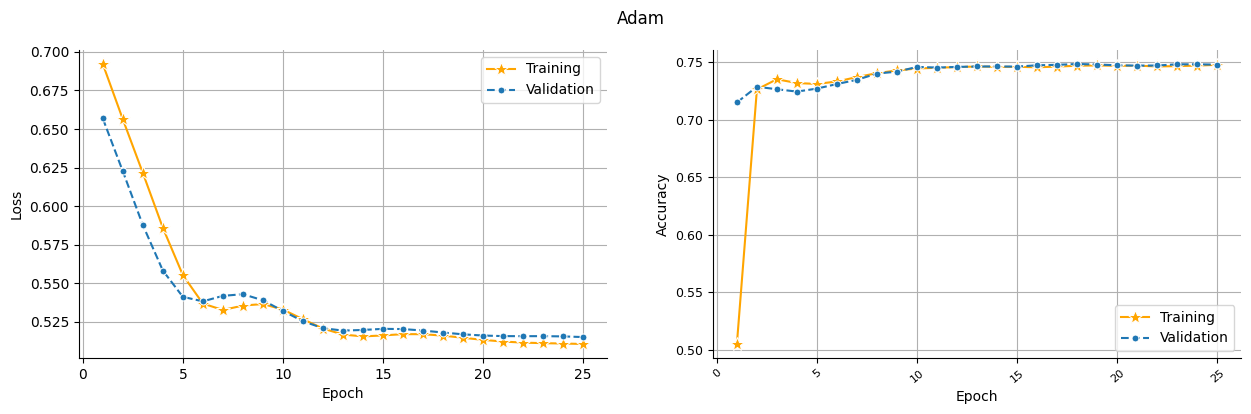

0
1


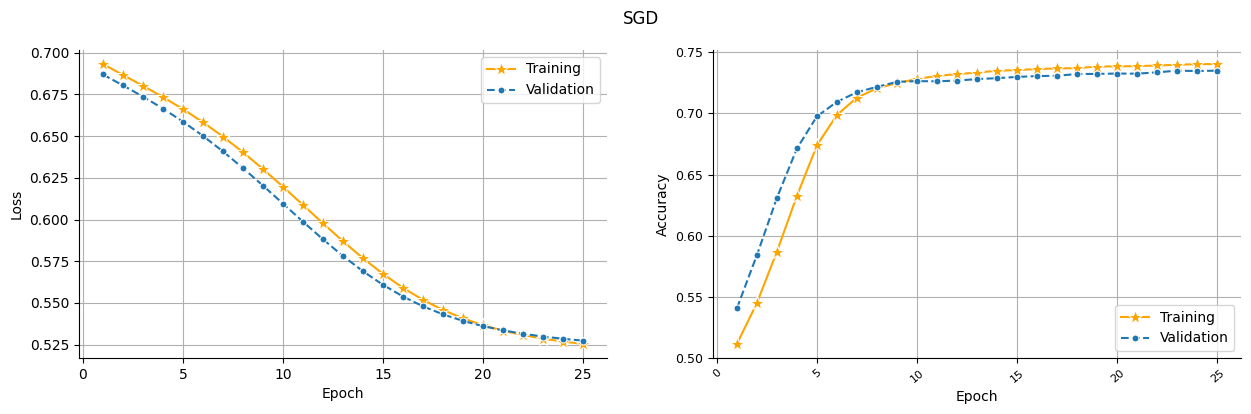

0
1


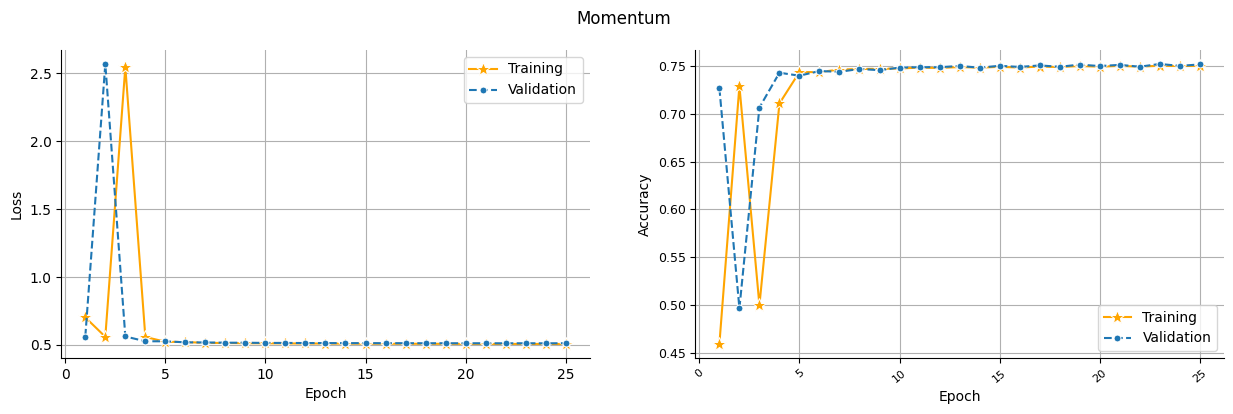

0
1


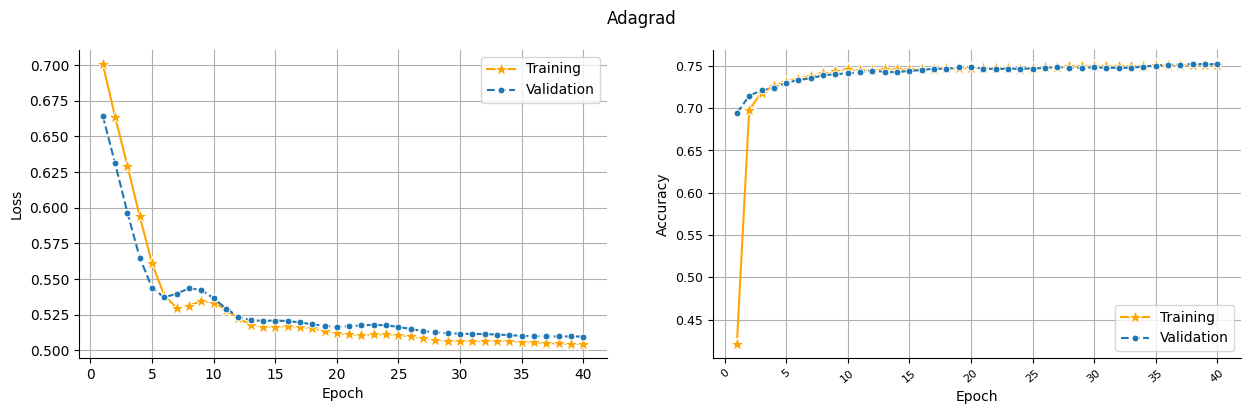

In [ ]:
plot_loss(experiment1['register_performance'], 'Adam')
plot_loss(experiment2['register_performance'], 'SGD')
plot_loss(experiment3['register_performance'], 'Momentum')
plot_loss(experiment4['register_performance'], 'Adagrad')

Al igual que lo que venimos viendo en los experimentos anteriores, no se observa sobreajuste en ninguno de los casos y se estabiliza el entrenamiento cerrca de la época 25. El modelo con optimizador SGD fue el que peor resultado dió (aunque sin mucha diferencias del resto). Los dos mejores fueron Adam y Adagrad. Hasta donde pudimos leer Adagrad sería menos costoso computacionalmente aunque tiene la tendencia a ser menos efectivo y muchas veces estancarse en el aprendizaje (las tasas de aprendizaje para los parámetros que tienen gradientes grandes se reducen drásticamente con el tiempo), pero este no es el caso ya que en 25 épocas logra estabilizarse el accuracy y el loss por lo que seleccionaremos este optimizador.

# Testeo del modelo seleccionado

Finalmente luego de las pruebas individuales de los hiperparámetros testeados, en general no hemos encontrado mucha diferencia en la performance de los modelos y  como modelo final elegimos el siguiente:   
- modelo base: llamado MLP con 2 layers y 32 neuronas la primer capa y 32*2 la segunda
- epochs:25
- funcion de activación: ReLU
- Optimizador: Adagrad


A continuación realizamos un testeo, reentrenado el modelo con todos los datos de train + validación, para testear en el data set X_test.

In [ ]:
## primero necesitamos concatenar train y val en uno solo y reescalar.
def scale_full_data(X_train, X_val):
    # Combina los datos de entrenamiento y validación
    X_full_train_np = np.concatenate((X_train, X_val), axis=0)
    scaler = StandardScaler()  # Convertimos a numpy para usar el scaler de sklearn
    X_full_train_scaled_np = scaler.fit_transform(X_full_train_np)  # Ajusta y transforma
    # Convierte de nuevo a tensores
    X_full_train_scaled = torch.Tensor(X_full_train_scaled_np).to(device)

    return X_full_train_scaled, scaler

In [ ]:
scale_full_data(X_train, X_val)

(tensor([[-1.1363, -1.0550,  0.1588,  ..., -0.9072, -1.5408,  0.5998],
         [ 0.8800,  0.9479, -6.2972,  ..., -0.5566,  0.6490, -1.6963],
         [ 0.8800,  0.9479,  0.1588,  ..., -1.6084,  0.6490, -0.7779],
         ...,
         [-1.1363, -1.0550,  0.1588,  ..., -1.6084,  0.6490,  1.0590],
         [ 0.8800, -1.0550,  0.1588,  ...,  0.4951,  0.6490,  1.0590],
         [ 0.8800,  0.9479,  0.1588,  ..., -0.2061, -1.5408, -0.7779]]),
 StandardScaler())

Creamos función para reentrenar con el modelo seleccionado con todos los datos y que devuelva el scaler (ya ajustado) para trasnformar el set de testeo

In [ ]:
def retrain_full_model(model, n_epochs, optimizer, X_train, y_train, X_val_s, y_val):
    print("Reescalando y reentrenando con los datos de entrenamiento y validación combinados...")

    # Escala los datos combinados
    X_full_train_scaled, scaler = scale_full_data(X_train, X_val)

    y_full_train = torch.cat((y_train, y_val), dim=0)  # Combina las etiquetas de train y val
    y_full_train = torch.Tensor(y_full_train).squeeze().unsqueeze(1).to(device)
    print(f"y_full_train shape: {y_full_train.shape}")
    # Reentrenar usando los datos escalados
    experiment_full = run_experiment(model, n_epochs, optimizer, X_full_train_scaled, y_full_train, X_full_train_scaled, y_full_train, stop_early=False, use_tqdm=False) ## aca se repite dos veces el set de entrenamiento y validacion ya que reutilizamos codigo
    #aunque no seria necesaria la validacion, es solo para obtener el mejor modelo del experimento en el entrenamiento (con el dataset completo)

    return experiment_full['best_model'], scaler

In [ ]:
def evaluate_on_test(model, X_test, y_test, scaler):
    model.eval()  # Cambia el modelo a modo de evaluación

    # Escala los datos de prueba utilizando el scaler ajustado con el conjunto completo
    X_test_scaled_np = scaler.transform(X_test)
    X_test_scaled = torch.Tensor(X_test_scaled_np).to(device)

    with torch.no_grad():  # No calculamos los gradientes en la evaluación
        y_pred_test = model(X_test_scaled)
        y_pred_c_test = (y_pred_test > 0).float()  # Sigmoid logits > 0 corresponde a predicción de clase 1

    # Calcula las métricas
    accuracy = accuracy_score(y_test.cpu(), y_pred_c_test.cpu())
    f1 = f1_score(y_test.cpu(), y_pred_c_test.cpu(), average='macro')
    conf_matrix = confusion_matrix(y_test.cpu(), y_pred_c_test.cpu())

    print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"Matriz de confusión:\n{conf_matrix}")

    return accuracy, f1, conf_matrix

In [ ]:
torch.manual_seed(seed)
n_inputs = len(features_columns)
n_hidden = 32 ## poquito para arrancar
activation_function = F.relu
n_outputs = 1
model = MLP(n_inputs, n_outputs, n_hidden, activation_function)
n_epochs = 25
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

In [ ]:
best_model_full, scaler_full = retrain_full_model(model, n_epochs, optimizer, X_train, y_train, X_val, y_val)

Reescalando y reentrenando con los datos de entrenamiento y validación combinados...
y_full_train shape: torch.Size([60088, 1])
Begin training...


Training Progress:   0%|          | 0/25 [00:05<?, ?epoch/s]

Training finished!
Completed training in 25 epochs 
	- Training Loss: 0.5071 
	- Validation Loss: 0.5068 
	- Training Accuracy: 0.7497 
	- Validation Accuracy: 0.7500 
	- Validation F1: 0.7491


In [ ]:
X_test = X_test.to_numpy()
accuracy_test, f1_test, conf_matrix_test = evaluate_on_test(best_model_full, X_test, y_test, scaler_full)

Accuracy en el conjunto de prueba: 0.7537
F1 score: 0.7531
Matriz de confusión:
[[3731 1616]
 [ 996 4261]]


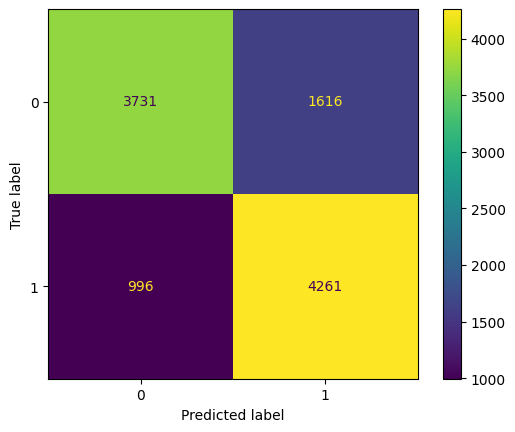

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)

disp.plot()

Finalmente vemos que el modelo no cae en performance en el test. La accuracy en el entrenamiento fue de 0.75 y en el test 0.7537, muy similares lo que nos muestra que la performance no dismunuyo en este set de testeo dividido al principio del práctico.  En general el principal problema del modelo es detectar la clase 0. Contiene muchos falsos positivos, La especificidad a es de 0.59 es decir que solo un 60 por ciento de los 0s estimados correctamente como 0s y el otro 40 por ciento son falsos positivos.

# Conclusión
A llo largo del trabajo práctico evaluamos la variación en diferentes hipérparametros, épocas, arquitectura, función de activación y optimizador. En todas ellas los resultados fueron muy similares, variando muy poco la performance de los modelos entre sí con accuracy en general cercana al 0.75. Una aclaración importante es que sería interesante realizar el testeo de hiperparámetros considerando conjuntamente la variación entre ellos, de esta manera podríamos encontrar combinaciones que podrían mejorar el modelo.
Con todo lo expuesto en este práctico el modelo que consideramos mejor predice la presencia de diabetes y prediabetes con las herramientas aquí presentadas fue el siguiente:
- modelo base: llamado MLP con 2 layers y 32 neuronas la primer capa y 32*2 la segunda
- epochs:25
- función de activación: ReLU
- Optimizador: Adagrad
Como ya explicamos este modelo funciona bastante bien pero tiene problemas principalmente con la clase 0s (pacientes sanos) por lo que consideramos sería poco acertado pornerlo operativo.